# Interactive Brokers Market Data

This tutorial covers the Interactive Brokers integration in chronos-lab for real-time and historical market data.

## What You'll Learn

- Connecting to IB Gateway/TWS and managing connections
- Understanding IB Contracts and why they matter
- Fetching historical data (non-streaming)
- Subscribing to streaming bar data
- Working with real-time tick data
- Direct access to IB API functions

## Prerequisites

### Software Requirements

1. **IB Gateway or TWS**: You must have Interactive Brokers Gateway or Trader Workstation installed and running
   - Download from: [Interactive Brokers](https://www.interactivebrokers.com/en/trading/tws.php)
   - Configure API access in Gateway/TWS settings
   
2. **chronos-lab with IB support**:

In [ ]:
!pip install chronos-lab[ib,arcticdb,visualization]

### Configuration

IB connection parameters are configured in `~/.chronos_lab/.env`. Key settings include:

```bash
IB_GATEWAY_HOST=127.0.0.1          # Gateway/TWS hostname
IB_GATEWAY_PORT=4001               # Port (4001 for Gateway)
IB_GATEWAY_READONLY=True           # Read-only mode (recommended)
IB_GATEWAY_CLIENT_ID=1             # Unique client ID
IB_REF_DATA_CONCURRENCY=10         # Max concurrent reference data requests
IB_HISTORICAL_DATA_CONCURRENCY=10  # Max concurrent historical data requests
```

**Read-Only Mode**: The IB module focuses on market data, not trading. We recommend using `IB_GATEWAY_READONLY=True` (the default). While ib_async can access portfolio and account data, that's outside the scope of this module.

For complete IB Gateway setup instructions, see the [IB API documentation](https://interactivebrokers.github.io/tws-api/).

## Understanding the IB Integration

### Architecture

The chronos-lab IB module is built on top of **ib_async** (formerly ib_insync), which provides a Pythonic wrapper around the Interactive Brokers API. Key characteristics:

1. **Stateful Connection**: Unlike Yahoo Finance or Intrinio, the IB module maintains a persistent connection
   - Requires explicit initialization: `get_ib()`
   - Connection lifecycle: connect → use → disconnect
   - Subscriptions persist until cancelled

2. **Singleton Pattern**: A single connection instance is shared across your application
   - Prevents duplicate connections
   - Manages connection state globally

3. **Async-First Design**: Maximum benefits come from using async functions
   - Concurrent contract qualification and data fetching
   - Semaphore-based rate limiting to avoid API violations
   - Parallel operations across multiple symbols

### What's Available

The IB module provides:
- **Historical data**: One-time fetches via `ohlcv_from_ib()` or `get_hist_data()`
- **Streaming bars**: Real-time bar updates via `subscribe_bars()`
- **Real-time ticks**: Bid/ask/last updates via `sub_tickers()`
- **Direct API access**: Advanced features via `ib.conn` (market depth, tick-by-tick, etc.)

### What's Not Covered

The IB API offers many additional market data functions that don't have specific chronos-lab wrappers:
- `reqHistoricalTicks` - Tick-level historical data
- `reqTickByTickData` - Ultra-granular real-time ticks
- `reqMktDepth` - Market depth (Level 2) data
- `reqMktDepthExchanges` - Available depth exchanges

These can be accessed directly via `ib.conn`. See the [ib-async documentation](https://ib-api-reloaded.github.io/ib_async/notebooks.html) for examples.

## Understanding IB Contracts

### What is a Contract?

In the IB API, a **Contract** is the fundamental way to identify a security. Unlike simple ticker symbols, contracts contain:

- `symbol`: The ticker symbol (e.g., "AAPL")
- `secType`: Security type ("STK" for stocks, "CASH" for forex, "FUT" for futures, etc.)
- `exchange`: Exchange code ("SMART" for smart routing, "NYSE", "NASDAQ", etc.)
- `currency`: Currency denomination ("USD", "EUR", etc.)
- `conId`: Contract ID - IB's unique identifier (obtained after qualification)

### Why Contracts Matter

**Symbol ambiguity problem**: A ticker symbol like "AA" can refer to multiple securities:
- Alcoa Corp on NYSE
- AA PLC on London Stock Exchange  
- Different share classes of the same company

Symbol-to-contract lookup is **non-deterministic**, especially for:
- International securities
- Multiple share classes
- Options and futures

**Best Practice**: While many chronos-lab functions accept symbols (for convenience), it's **highly advisable to work with contracts** when you need precision.

### Contract Lifecycle

```
1. Create → Contract(secType='STK', symbol='AAPL', exchange='SMART', currency='USD')
2. Qualify → ib.symbols_to_contracts() or ib.conn.qualifyContracts()
3. Get Details → ib.lookup_cds() [optional, for additional metadata]
```

After qualification, the contract has a `conId` and can be used with IB API functions.

See the **Appendix** at the end of this notebook for detailed contract examples.

## Setup: Connection & Initialization

Let's start by importing the necessary modules and establishing a connection to IB Gateway/TWS.

In [1]:
from chronos_lab.ib import get_ib, hist_to_ohlcv
from chronos_lab.sources import ohlcv_from_ib_async, ohlcv_from_ib
from chronos_lab.storage import ohlcv_to_arcticdb
from ib_async import util, Contract
import pandas as pd

### Starting the Event Loop

When using ib_async in Jupyter notebooks, we need to start the event loop explicitly:

In [2]:
util.startLoop()

### Getting the IB Connection

The `get_ib()` function returns the singleton IBMarketData instance and ensures it's connected:

In [ ]:
# Get singleton instance and connect
ib = get_ib()

# Check connection status
if ib._connected:
    print("✓ Connected to IB Gateway/TWS")
else:
    print("✗ Connection failed - check IB Gateway/TWS is running")

## Historical Data (Non-Streaming)

Historical data fetches are one-time requests for past OHLCV data. There are two approaches:

### High-Level: ohlcv_from_ib()

The convenience function `ohlcv_from_ib()` / `ohlcv_from_ib_async()` provides the simplest interface:

In [4]:
# Fetch 6 months of daily data for tech stocks
symbols = ["AAPL", "MSFT", "GOOGL", "NVDA"]

# Async version (recommended for multiple symbols)
hist_data = await ohlcv_from_ib_async(
    symbols=symbols,
    period="6m",
    interval="1d"
)

print(f"Downloaded {len(hist_data)} rows for {len(hist_data.index.get_level_values('symbol').unique())} symbols")
hist_data.head(10)

Downloaded 736 rows for 4 symbols


/Users/vitalik/python/chronos-lab/chronos_lab/ib.py:415: RuntimeWarning: '<' not supported between instances of 'Contract' and 'Contract', sort order is undefined for incomparable objects.
  return pd.concat(indexed_dfs, sort=False)


,,open,high,low,close,volume,conId
date,symbol,,,,,,
2025-05-19 00:00:00+00:00,AAPL,207.15,208.84,203.64,208.15,26756989.0,265598
2025-05-20 00:00:00+00:00,AAPL,207.04,207.84,204.41,206.23,23605310.0,265598
2025-05-21 00:00:00+00:00,AAPL,204.55,206.41,200.10,201.48,37401976.0,265598
2025-05-22 00:00:00+00:00,AAPL,200.10,202.13,199.17,200.75,29211675.0,265598
2025-05-23 00:00:00+00:00,AAPL,193.08,197.10,192.87,194.68,48786206.0,265598
2025-05-27 00:00:00+00:00,AAPL,197.69,200.13,196.83,199.60,33512768.0,265598
2025-05-28 00:00:00+00:00,AAPL,199.92,202.11,199.29,199.81,23931371.0,265598
2025-05-29 00:00:00+00:00,AAPL,202.87,203.19,197.91,199.34,30417140.0,265598
2025-05-30 00:00:00+00:00,AAPL,198.79,201.35,196.18,200.24,28569153.0,265598


**Benefits of ohlcv_from_ib():**
- Automatically creates and qualifies contracts from symbols
- Returns chronos-lab standard format (date, symbol) MultiIndex
- Handles IB API parameter conversion
- Async version fetches multiple symbols concurrently
- Compatible with `ohlcv_to_arcticdb()` for storage

### Low-Level: get_hist_data()

For more control over IB API parameters, use `get_hist_data()` or `get_hist_data_async()`:

In [5]:
# First, create and qualify contracts
contracts = await ib.symbols_to_contracts_async(["AAPL", "MSFT"])

print(f"Qualified {len(contracts)} contracts")
for contract in contracts:
    print(f"  {contract.symbol}: conId={contract.conId}")

# Fetch historical data with IB API parameters
hist_data_raw = await ib.get_hist_data_async(
    contracts=contracts,
    duration="30 D",      # IB duration format
    barsize="1 day",      # IB bar size format
    datatype="TRADES",    # Data type
    userth=True          # Regular trading hours only
)

print(f"\nRaw data shape: {hist_data_raw.shape}")
hist_data_raw.head()

Qualified 2 contracts
  AAPL: conId=265598
  MSFT: conId=272093

Raw data shape: (60, 8)


open  \
contract                                           datatype date                                
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  272.70   
                                                            2025-12-30 00:00:00+00:00  272.81   
                                                            2025-12-31 00:00:00+00:00  273.06   
                                                            2026-01-02 00:00:00+00:00  272.25   
                                                            2026-01-05 00:00:00+00:00  270.72   

                                                                                         high  \
contract                                           datatype date                                
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  274.36   
                                                            2025-12-30 00:00:00+00:00  274.08   
                                                            2025-12-31 00:00:00+00:00  273.68   
                                                            2026-01-02 00:00:00+00:00  277.84   
                                                            2026-01-05 00:00:00+00:00  271.51   

                                                                                          low  \
contract                                           datatype date                                
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  272.35   
                                                            2025-12-30 00:00:00+00:00  272.28   
                                                            2025-12-31 00:00:00+00:00  271.75   
                                                            2026-01-02 00:00:00+00:00  269.00   
                                                            2026-01-05 00:00:00+00:00  266.14   

                                                                                        close  \
contract                                           datatype date                                
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  273.76   
                                                            2025-12-30 00:00:00+00:00  273.08   
                                                            2025-12-31 00:00:00+00:00  271.86   
                                                            2026-01-02 00:00:00+00:00  271.01   
                                                            2026-01-05 00:00:00+00:00  267.26   

                                                                                           volume  \
contract                                           datatype date                                    
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  10098230.0   
                                                            2025-12-30 00:00:00+00:00  11846812.0   
                                                            2025-12-31 00:00:00+00:00  11592691.0   
                                                            2026-01-02 00:00:00+00:00  21546382.0   
                                                            2026-01-05 00:00:00+00:00  23355082.0   

                                                                                       average  \
contract                                           datatype date                                 
Contract(secType='STK', conId=265598, symbol='A... TRADES   2025-12-29 00:00:00+00:00  273.555   
                                                            2025-12-30 00:00:00+00:00  273.029   
                                                            2025-12-31 00:00:00+00:00  272.580   
                                                            2026-01-02 00:00:00+00:00  272.209   
                                                            2026-01-05 00

The raw format uses `(contract, datatype, date)` as index. Convert to chronos-lab format with `hist_to_ohlcv()`:

In [6]:
# Convert to standard OHLCV format
ohlcv_data = hist_to_ohlcv(hist_data_raw)

print(f"Converted data shape: {ohlcv_data.shape}")
ohlcv_data.tail()

Converted data shape: (60, 6)


,,open,high,low,close,volume,conId
date,symbol,,,,,,
2026-02-04 00:00:00+00:00,MSFT,410.97,419.80,409.24,414.19,26975115.0,272093
2026-02-05 00:00:00+00:00,MSFT,408.00,408.30,392.32,393.67,41928389.0,272093
2026-02-06 00:00:00+00:00,MSFT,399.39,401.79,393.00,401.14,33652590.0,272093
2026-02-09 00:00:00+00:00,MSFT,404.62,414.89,400.87,413.60,25849992.0,272093
2026-02-10 00:00:00+00:00,MSFT,419.61,423.68,414.71,419.99,14917269.0,272093


### Storing to ArcticDB

Historical data can be persisted to ArcticDB for later use:

In [7]:
# Store historical data
result = ohlcv_to_arcticdb(
    ohlcv=hist_data,
    library_name='ib_data',
    backend='LMDB'
)

if result['statusCode'] == 0:
    print(f"✓ Stored {len(hist_data.index.get_level_values('symbol').unique())} symbols to ArcticDB")

✓ Stored 4 symbols to ArcticDB


### Visualizing Historical Data

Let's create a candlestick chart using mplfinance:

Chart created for NVDA (184 bars)


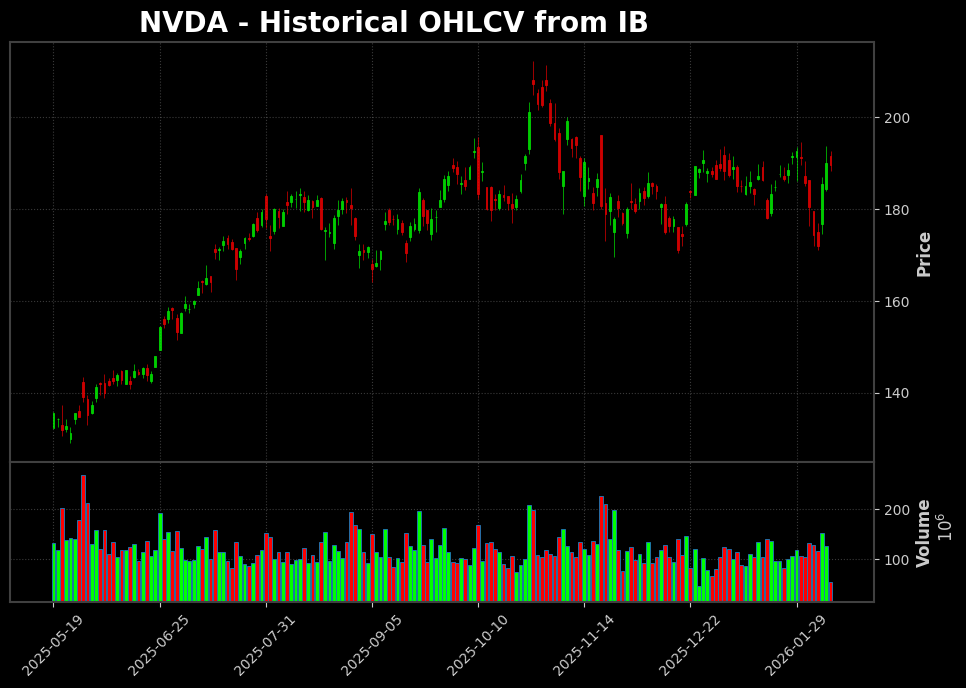

In [8]:
import mplfinance as mpf
from chronos_lab.plot import bloomberg_style

# Select a single symbol for plotting
symbol = "NVDA"
chart_data = hist_data.xs(symbol, level='symbol')

# Create candlestick chart
fig, axes = mpf.plot(
    chart_data,
    type='candle',
    style=bloomberg_style,
    volume=True,
    figsize=(12, 8),
    panel_ratios=(3, 1),
    returnfig=True,
    ylabel='Price',
    ylabel_lower='Volume',
    datetime_format='%Y-%m-%d'
)

# Style adjustments
for ax in axes:
    ax.set_facecolor('#000000')
    ax.grid(True, which='major', linestyle=':', linewidth=0.8, color='#C0C0C0')

fig.suptitle(
    f"{symbol} - Historical OHLCV from IB",
    color='white',
    fontsize=20,
    y=0.92
)

print(f"Chart created for {symbol} ({len(chart_data)} bars)")

## Streaming Bar Data

Streaming bars provide real-time or near-real-time updates. Unlike historical fetches, subscriptions remain active and continuously update.

### High-Level: subscribe_bars()

The simplest way to subscribe to streaming data:

In [9]:
# Subscribe to 5-minute bars for tech stocks
contract_ids = await ib.subscribe_bars_async(
    symbols=["AAPL", "MSFT", "GOOGL"],
    period="1d",      # How much history to fetch initially
    interval="5m",    # Bar interval
    realtime=False    # Use keepUpToDate historical bars (not real-time bars)
)

print(f"✓ Subscribed to {len(contract_ids)} contracts for streaming")
print(f"Contract IDs: {contract_ids}")

✓ Subscribed to 3 contracts for streaming
Contract IDs: [265598, 272093, 208813719]


**About the `realtime` parameter:**

- `realtime=False` (default): Uses IB's `reqHistoricalData()` with `keepUpToDate=True` for streaming updates
  - Respects the `interval` parameter (e.g., "5m", "1h", "1d")
  - Provides historical data plus ongoing updates
  - Most flexible option for various time intervals

- `realtime=True`: Uses IB's `reqRealTimeBars()` API
  - **Special case**: Always returns 5-second bars regardless of the `interval` parameter
  - IB API limitation: 5-second bars are the only interval available with `reqRealTimeBars()`
  - Use this only when you specifically need 5-second granularity without historical data
  - Note: The `interval` parameter is ignored when `realtime=True`

### Retrieving Streaming Data

Use `get_bars()` to retrieve current bar data from active subscriptions:

In [10]:
util.sleep(0)

# Retrieve all bars
bars_df = ib.get_bars()

print(f"Retrieved {len(bars_df)} bars")
bars_df.tail(10)

Retrieved 114 bars


,,open,high,low,close,volume,conId
date,symbol,,,,,,
2026-02-10 16:50:00+00:00,GOOGL,318.84,318.87,318.24,318.38,179069.0,208813719
2026-02-10 16:55:00+00:00,GOOGL,318.36,318.58,318.13,318.32,173129.0,208813719
2026-02-10 17:00:00+00:00,GOOGL,318.30,318.41,318.12,318.41,150189.0,208813719
2026-02-10 17:05:00+00:00,GOOGL,318.41,319.28,318.22,319.27,171078.0,208813719
2026-02-10 17:10:00+00:00,GOOGL,319.27,319.52,319.03,319.16,176815.0,208813719
2026-02-10 17:15:00+00:00,GOOGL,319.14,319.58,319.10,319.22,176682.0,208813719
2026-02-10 17:20:00+00:00,GOOGL,319.22,319.25,318.72,318.73,105629.0,208813719
2026-02-10 17:25:00+00:00,GOOGL,318.73,319.35,318.65,319.11,116296.0,208813719
2026-02-10 17:30:00+00:00,GOOGL,319.10,319.42,319.08,319.26,113923.0,208813719


### Filtering Bar Data

`get_bars()` supports flexible filtering:

In [11]:
# Get only AAPL bars
aapl_bars = ib.get_bars(symbols=["AAPL"])
print(f"AAPL: {len(aapl_bars)} bars\n")
print(aapl_bars.tail())

# Get last 10 bars per symbol
recent_bars = ib.get_bars(last=10)
print(f"\nLast 10 bars per symbol: {len(recent_bars)} total bars")

# Get bars for specific date range
today = pd.Timestamp.now(tz='UTC').normalize()
date_filtered = ib.get_bars(start_date=today)
print(f"\nToday's bars: {len(date_filtered)} bars")

AAPL: 38 bars

                                    open    high     low   close    volume  \
date                      symbol                                             
2026-02-10 17:15:00+00:00 AAPL    273.47  273.49  273.13  273.17  137847.0   
2026-02-10 17:20:00+00:00 AAPL    273.16  273.27  272.94  273.10  298773.0   
2026-02-10 17:25:00+00:00 AAPL    273.10  273.40  273.06  273.35  123473.0   
2026-02-10 17:30:00+00:00 AAPL    273.35  273.53  273.24  273.30  117350.0   
2026-02-10 17:35:00+00:00 AAPL    273.29  273.32  273.15  273.23   48454.0   

                                   conId  
date                      symbol          
2026-02-10 17:15:00+00:00 AAPL    265598  
2026-02-10 17:20:00+00:00 AAPL    265598  
2026-02-10 17:25:00+00:00 AAPL    265598  
2026-02-10 17:30:00+00:00 AAPL    265598  
2026-02-10 17:35:00+00:00 AAPL    265598  

Last 10 bars per symbol: 30 total bars

Today's bars: 114 bars


### Unsubscribing

Cancel subscriptions to free up resources:

In [12]:
# Unsubscribe from specific contracts
# ib.unsub_bars(contract_ids=[contract_ids[0]])

# Or unsubscribe from all
ib.unsub_bars()
print("✓ Unsubscribed from all bar subscriptions")

✓ Unsubscribed from all bar subscriptions


### Low-Level: sub_bars()

For direct control over IB API parameters:

In [13]:
# Create contracts
contracts = await ib.symbols_to_contracts_async(["TSLA"])

# Subscribe with explicit IB parameters
await ib.sub_bars_async(
    contracts=contracts,
    endDateTime="",
    durationStr="1 D",
    barSizeSetting="1 min",
    whatToShow="TRADES",
    useRTH=False,          # Include extended hours
    keepUpToDate=True,     # Streaming mode
    formatDate=2,
    realtime=False
)

print("✓ Subscribed to TSLA with custom parameters")

✓ Subscribed to TSLA with custom parameters


## Real-Time Tick Data

Tick data provides real-time updates for bid, ask, last price, and other market data fields.

### Subscribing to Tickers

In [14]:
# Create contracts
contracts = await ib.symbols_to_contracts_async(["AAPL", "MSFT", "GOOGL"])

# Subscribe to tick updates
ib.sub_tickers(
    contracts=contracts,
    gen_tick_list=''  # Basic ticks; use ib.gen_tick_list for comprehensive data
)

print(f"✓ Subscribed to tickers for {len(contracts)} contracts")

✓ Subscribed to tickers for 3 contracts


### Retrieving Tick Data

In [15]:
# Wait for data
util.sleep(0)

# Get current tick data
tickers_df = ib.get_tickers()

print(f"Current tick data for {len(tickers_df)} symbols:")
tickers_df[['last', 'bid', 'ask', 'bidSize', 'askSize', 'marketPrice']]

Current tick data for 3 symbols:


,last,bid,ask,bidSize,askSize,marketPrice
symbol,,,,,,
AAPL,273.35,273.34,273.35,100.0,200.0,273.35
MSFT,420.00,419.99,420.01,80.0,280.0,420.00
GOOGL,319.33,319.30,319.32,600.0,100.0,319.31


### Analyzing Bid-Ask Spreads

In [16]:
# Calculate bid-ask spreads
if len(tickers_df) > 0:
    tickers_df['spread'] = tickers_df['ask'] - tickers_df['bid']
    tickers_df['spread_pct'] = (tickers_df['spread'] / tickers_df['marketPrice']) * 100
    
    print("Bid-Ask Spread Analysis:")
    print(tickers_df[['bid', 'ask', 'spread', 'spread_pct']].round(4))
else:
    print("No tick data available yet")

Bid-Ask Spread Analysis:
           bid     ask  spread  spread_pct
symbol                                    
AAPL    273.34  273.35    0.01      0.0037
MSFT    419.99  420.01    0.02      0.0048
GOOGL   319.30  319.32    0.02      0.0063


### Unsubscribing from Tickers

In [17]:
# Unsubscribe from all tickers
ib.unsub_tickers()
print("✓ Unsubscribed from all tick subscriptions")

✓ Unsubscribed from all tick subscriptions


## Advanced: Direct IB API Access

The IB API provides many functions beyond what chronos-lab wraps. Access them directly via `ib.conn`.

### Example: Market Depth

Market depth (Level 2 data) shows the full order book. Here's a simple example:

In [18]:
# Check which exchanges support market depth
exchanges = ib.conn.reqMktDepthExchanges()

print(f"Exchanges with market depth support: {len(exchanges)}")
for ex in exchanges[:5]:  # Show first 5
    print(f"  {ex.exchange}: {ex.secType}")

Exchanges with market depth support: 304
  DTB: OPT
  COMEX: FOP
  LSEETF: STK
  SGX: FUT
  IDEALPRO: CASH


In [19]:
# Subscribe to market depth for a contract
contract = (await ib.symbols_to_contracts_async(["AAPL"]))[0]

depth_ticker = ib.conn.reqMktDepth(contract, numRows=5)
print(f"Subscribed to market depth for {contract.symbol}")

# Wait for data
util.sleep(3)

# Display order book
print(f"\nBids (top 5):")
for bid in depth_ticker.domBids[:5]:
    print(f"  {bid.size:6} @ {bid.price:.2f}")

print(f"\nAsks (top 5):")
for ask in depth_ticker.domAsks[:5]:
    print(f"  {ask.size:6} @ {ask.price:.2f}")

# Cancel subscription
ib.conn.cancelMktDepth(contract)
print("\n✓ Cancelled market depth subscription")

Subscribed to market depth for AAPL

Bids (top 5):

Asks (top 5):

✓ Cancelled market depth subscription


### More Examples

For additional examples of direct IB API usage, see the [ib-async documentation](https://ib-api-reloaded.github.io/ib_async/notebooks.html):
- Historical tick data
- Tick-by-tick data
- Options chains
- Fundamental data
- News feeds

## Cleanup: Disconnecting

Always disconnect when done to cleanly close the connection:

In [ ]:
# Disconnect cleans up all subscriptions automatically
ib.disconnect()
print("✓ Disconnected from IB Gateway/TWS")

---

## Appendix

### Contract Details Deep Dive

#### Creating Contracts

Create contracts manually for precise control:

In [20]:
from ib_async import Contract

# Stock contract
stock = Contract(
    secType='STK',
    symbol='AAPL',
    exchange='SMART',
    currency='USD'
)

# Forex contract
forex = Contract(
    secType='CASH',
    symbol='EUR',
    currency='USD'
)

contracts = [stock, forex]

print("Created contracts (not yet qualified)")
print(f"Stock conId: {stock.conId}")  # Will be 0 until qualified
print(f"Forex conId: {forex.conId}")

Created contracts (not yet qualified)
Stock conId: 0
Forex conId: 0


#### Qualifying Contracts

Qualification fills in missing details and obtains the `conId`:

In [21]:
# Reconnect if needed
if not ib._connected:
    ib = get_ib()

# Qualify contracts
qualified = ib.conn.qualifyContracts(*contracts)

print("Qualified contracts:")
for contract in qualified:
    print(f"  {contract.symbol} ({contract.secType}): conId={contract.conId}")

Qualified contracts:
  AAPL (STK): conId=265598
  EUR (CASH): conId=12087792


#### Getting Contract Details

Contract details provide comprehensive metadata:

In [22]:
# Lookup contract details
await ib.lookup_cds_async(qualified)

# Retrieve as DataFrame
details_df = ib.get_cds()

print(f"Contract details for {len(details_df)} contracts:")
print(details_df[['conId', 'longName', 'industry', 'category']].head())

Contract details for 2 contracts:
           conId                      longName    industry   category
symbol                                                               
AAPL      265598                     APPLE INC  Technology  Computers
EUR     12087792  European Monetary Union Euro                       


### Configuration Reference

Complete list of IB-related settings in `~/.chronos_lab/.env`:

#### Connection Settings
- **IB_GATEWAY_HOST**: Gateway/TWS hostname (default: `127.0.0.1`)
- **IB_GATEWAY_PORT**: Port number (default: `4002` for Gateway, `7497` for TWS paper trading)
- **IB_GATEWAY_READONLY**: Read-only mode (default: `True`)
- **IB_GATEWAY_CLIENT_ID**: Unique client identifier (default: `1`)
- **IB_GATEWAY_ACCOUNT**: IB account identifier (optional)

#### Rate Limiting
- **IB_REF_DATA_CONCURRENCY**: Max concurrent reference data requests (default: `10`)
- **IB_HISTORICAL_DATA_CONCURRENCY**: Max concurrent historical data requests (default: `10`)

### Troubleshooting

#### Connection Issues
- **"Connection refused"**: Check that IB Gateway/TWS is running
- **"Already connected"**: Another client is using the same client ID
  - Solution: Change `IB_GATEWAY_CLIENT_ID` in `.env`

#### Data Issues
- **"No data returned"**: Contract not found or market closed
- **"Pacing violation"**: Too many requests too quickly
  - Solution: Reduce concurrency settings or add delays
- **"Historical data limit exceeded"**: Requested period too long for bar size
  - Solution: Use larger bar size or shorter period

#### Port Numbers
- Gateway live: `4001`
- Gateway paper: `4002` (recommended for testing)
- TWS live: `7496`
- TWS paper: `7497`

### IB API Limitations

The IB API has specific constraints on historical data requests:

| Bar Size | Maximum Duration |
|----------|------------------|
| 1 sec - 30 secs | 30 minutes |
| 1 min - 30 mins | 30 days |
| 1 hour - 8 hours | 30 days |
| 1 day | 1 year |
| 1 week - 1 month | 1 year |

The chronos-lab functions handle these constraints automatically and will warn if overfetching is required.

### Next Steps

Now that you understand IB integration, consider:
- Combining IB data with other sources (Yahoo Finance, Intrinio)
- Building real-time monitoring dashboards
- Creating automated data pipelines with ArcticDB storage
- Exploring advanced IB features (options, futures, forex)

See the [Getting Started tutorial](/chronos-lab/tutorials/getting-started) for more on data workflows and storage patterns.